## Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Option 1

In [ ]:
# Patient has visit -> all days are 1
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Loop through each user group
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    if (group['visit_day'] == 1).any():
        # Set all rows for this user to 1 in the original dataframe
        fitbit_data.loc[fitbit_data['fitbit_user_id'] == user_id, 'visit_day'] = 1

Option 2

In [3]:
# Load your data
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Iterate by user
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    visit_days = group[group['visit_day'] == 1]['days'].values

    for visit_day in visit_days:
        # Get range from (visit_day - 14) to (visit_day + 14)
        lower = visit_day - 14
        upper = visit_day + 14

        # Create mask for the affected rows for this user
        mask = (
            (fitbit_data['fitbit_user_id'] == user_id) &
            (fitbit_data['days'] >= lower) &
            (fitbit_data['days'] <= upper)
        )

        fitbit_data.loc[mask, 'visit_day'] = 1

In [4]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

In [5]:
# Organizing columns
measure_cols = ['avgWeight_per_day', 'calories', 'heart', 'steps']
survey_cols = ['diet', 'medication', 'symptoms']
result_col = 'visit_day'

In [6]:
fitbit_data[result_col] = fitbit_data[result_col].fillna(0)

In [7]:
def fix_survey_cols(df, cols):
    df = df.copy()

    # Sort by user and date to ensure proper shifting
    df = df.sort_values(by=['fitbit_user_id', 'date'])

    # Shift survey columns backward by one day within each user group
    for col in cols:
        df[f'{col}_cur'] = df.groupby('fitbit_user_id')[col].shift(-1)

    return df

fitbit_data = fix_survey_cols(fitbit_data, survey_cols)

In [8]:
survey_cols = ['diet_cur', 'medication_cur', 'symptoms_cur']

In [9]:
def one_hot_encode_with_nan(df, cols):
    df = df.copy()
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)

        # Set dummy rows to np.nan where original was NaN
        dummies[df[col].isna()] = np.nan

        # Convert dummies to float so XGBoost can handle them
        dummies = dummies.astype(float)

        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=[col], inplace=True)
    return df

fb_data = one_hot_encode_with_nan(fitbit_data, survey_cols)

/tmp/ipython-input-9-782764484.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-9-782764484.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-9-782764484.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dummies[df[col].isna()] = np.nan
/tmp/ipython-input-9-782764484.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an er

In [10]:
scaler = MinMaxScaler().fit(fb_data[measure_cols])
fb_data[measure_cols] = scaler.transform(fb_data[measure_cols])

In [11]:
oneh_cols = ['diet_cur_0.0', 'diet_cur_1.0', 'diet_cur_2.0', 'medication_cur_0.0', 'medication_cur_1.0', 'medication_cur_2.0', 'symptoms_cur_0.0', 'symptoms_cur_1.0', 'symptoms_cur_2.0']

In [ ]:
fb_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,...,visit_day,diet_cur_0.0,diet_cur_1.0,diet_cur_2.0,medication_cur_0.0,medication_cur_1.0,medication_cur_2.0,symptoms_cur_0.0,symptoms_cur_1.0,symptoms_cur_2.0
0,0,2021-07-27,App Money,1,0.533696,0.198254,0.365854,0.169098,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,2021-07-28,App Money,1,0.530795,0.223150,0.365854,0.291869,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2,2021-07-29,App Money,1,0.529767,0.200683,0.378049,0.223987,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,2021-07-30,App Money,1,0.526443,0.230285,0.365854,0.222853,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,4,2021-07-31,App Money,1,0.525033,0.215484,0.365854,0.208104,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,0.150057,0.341463,0.089060,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44816,44816,2025-03-13,No App,307,NaN,0.143074,0.329268,0.100756,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44817,44817,2025-03-14,No App,307,NaN,0.171689,0.341463,0.179822,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44818,44818,2025-03-15,No App,307,NaN,0.169032,0.341463,0.205997,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## KFold Cross Validation

In [12]:
x = fb_data[measure_cols+oneh_cols+['fitbit_user_id']]
targets = fb_data[result_col].astype(int)

sgkf = StratifiedGroupKFold(n_splits=10)

groups = x['fitbit_user_id']

In [13]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)

In [ ]:
xgb_1 = XGBClassifier(random_state=42, n_jobs=-1, subsample=0.8, n_estimators = 200, max_depth = 3, learning_rate = 0.01, colsample_bytree = 0.8)
xgb_2 = XGBClassifier(random_state=42, n_jobs=-1, subsample=0.8, n_estimators = 200, max_depth = 4, learning_rate = 0.01, colsample_bytree = 0.8)

In [ ]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="roc_auc")

array([0.46612024, 0.49628715, 0.73005905, 0.54165346, 0.54976127,
       0.58186532, 0.54335686, 0.57978749, 0.3701029 , 0.63537125])

In [ ]:
cross_val_score(xgb_1, x, targets, groups=groups, cv=sgkf, scoring="roc_auc")

array([0.58211498, 0.56904061, 0.78396513, 0.53766375, 0.69046423,
       0.57864954, 0.69576861, 0.66298831, 0.7912602 , 0.64273184])

In [ ]:
cross_val_score(xgb_2, x, targets, groups=groups, cv=sgkf, scoring="roc_auc")

array([0.60667751, 0.54931415, 0.7716954 , 0.52595525, 0.68443679,
       0.59406261, 0.68169359, 0.64672108, 0.70727145, 0.651279  ])

In [ ]:
cross_val_score(xgb_1, x, targets, groups=groups, cv=sgkf, scoring="average_precision")

array([0.07817633, 0.06045079, 0.13055274, 0.08057777, 0.06814008,
       0.06921432, 0.09646357, 0.07802746, 0.1132986 , 0.08780362])

In [ ]:
cross_val_score(xgb_1, x, targets, groups=groups, cv=sgkf, scoring="f1")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Tuning Hyperparameters

In [14]:
# Define parameter space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # more = better, but slower
    scoring='f1',  # Or "average_precision", "f1", etc.
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1,
    random_state=42
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best ROC AUC: 0.022374212050182786


In [ ]:
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],
    'max_depth': [5, 6, 7],
    'n_estimators': [50, 100, 150]
}

search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best params: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 50}
Best ROC AUC: 0.6222279575481915


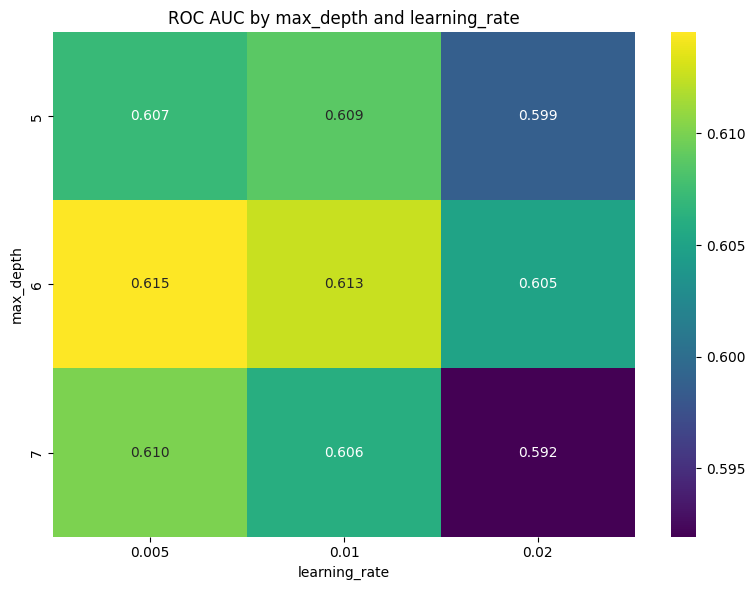

In [ ]:
results = pd.DataFrame(search.cv_results_)

# Create a pivot table
pivot = results.pivot_table(
    index='param_max_depth',
    columns='param_learning_rate',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("ROC AUC by max_depth and learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

ROC Curves + Confusion Matricies

In [17]:
best_params_week = {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
best_params_user = {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bytree': 0.6}

In [15]:
def train_evaluate_visualize(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    # Hard predictions
    y_pred_train = model.predict(X_train)
    y_pred_val   = model.predict(X_val)

    # Probabilities for ROC/AUC
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_val   = model.predict_proba(X_val)[:, 1]

    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc   = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train)
    val_auc   = roc_auc_score(y_val, y_prob_val)

    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob_val)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_prob_val)
    avg_precision = average_precision_score(y_val, y_prob_val)
    plt.figure()
    plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return model, train_acc, val_acc, train_auc, val_auc

Train  Acc: 0.995,  Validation Acc: 0.943
Train  AUC: 0.999,  Validation AUC: 0.423


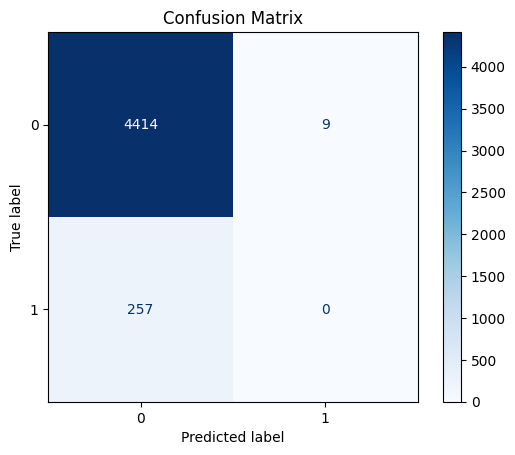

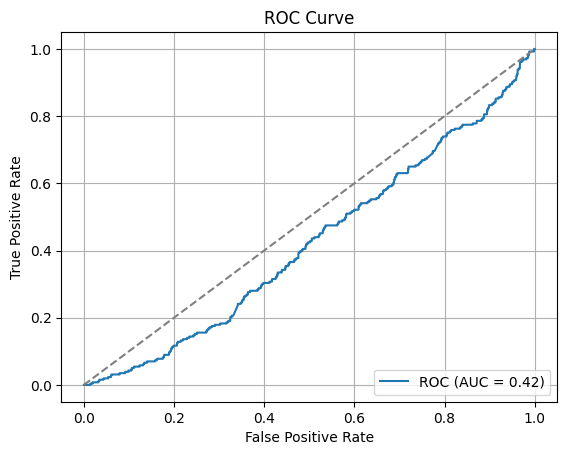

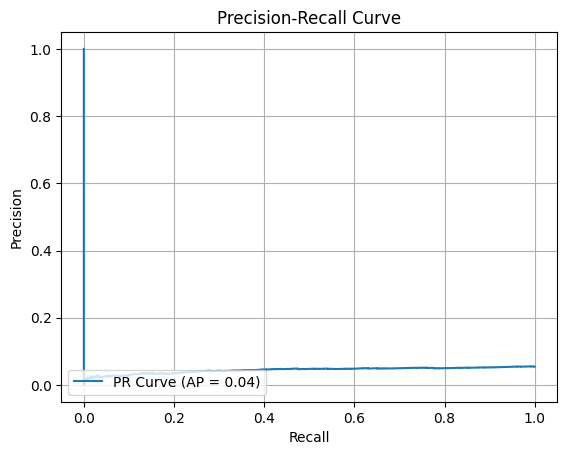

Train  Acc: 0.995,  Validation Acc: 0.941
Train  AUC: 0.999,  Validation AUC: 0.481


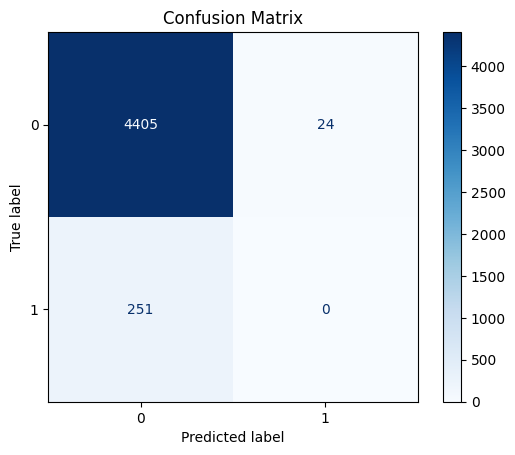

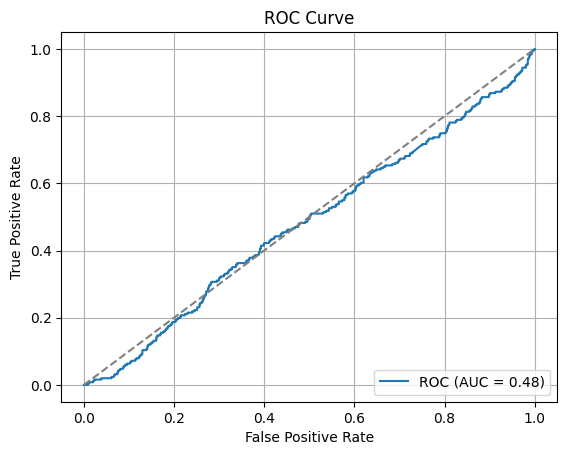

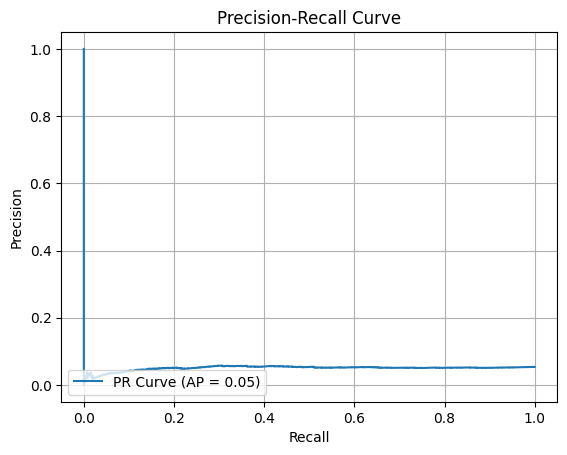

Train  Acc: 0.996,  Validation Acc: 0.945
Train  AUC: 0.999,  Validation AUC: 0.685


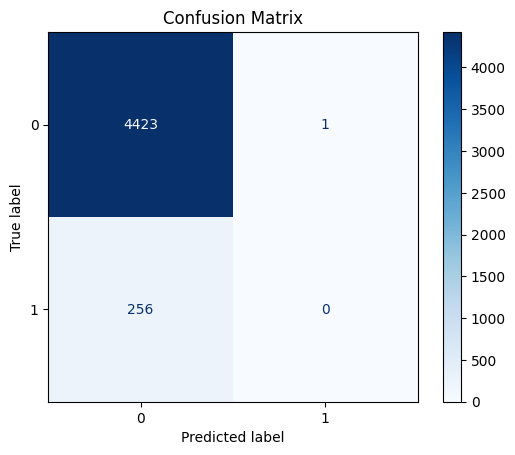

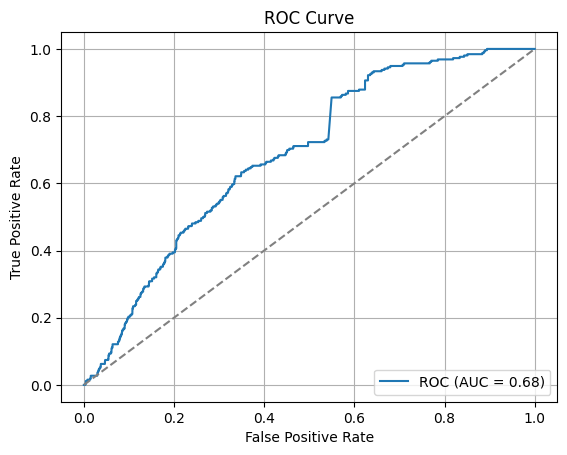

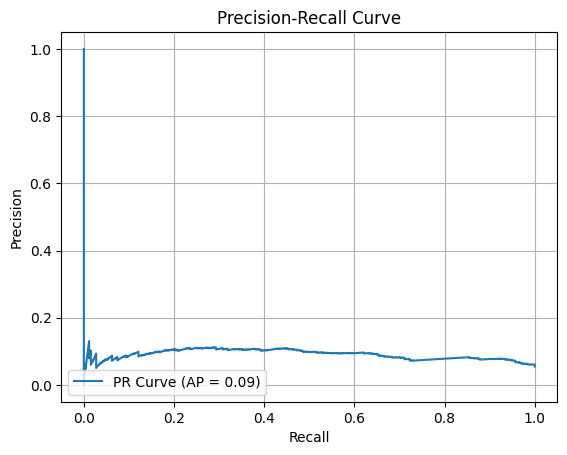

Train  Acc: 0.995,  Validation Acc: 0.961
Train  AUC: 0.999,  Validation AUC: 0.535


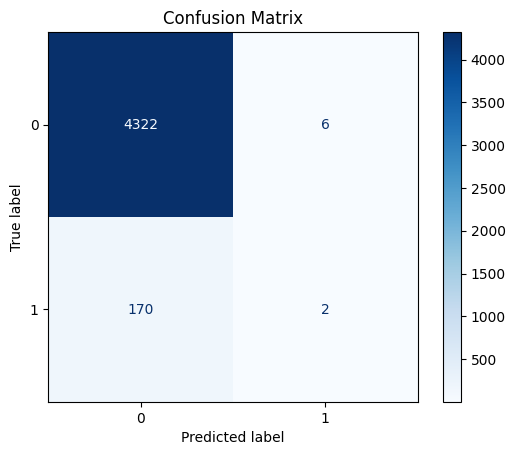

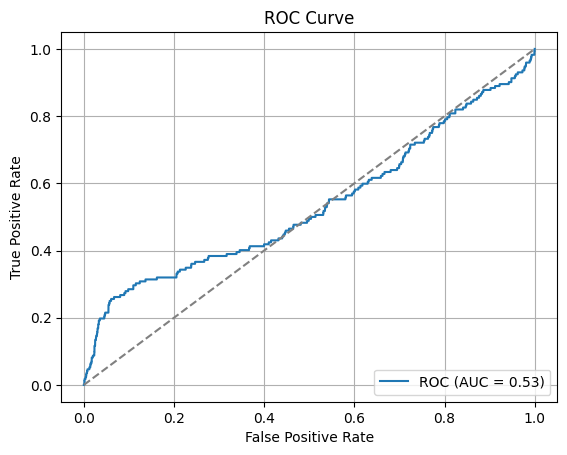

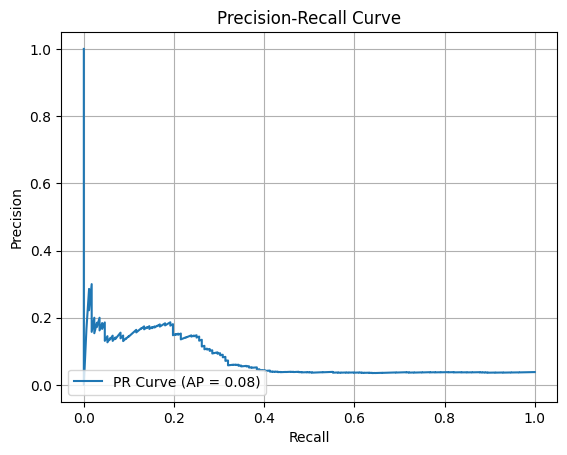

Train  Acc: 0.996,  Validation Acc: 0.950
Train  AUC: 0.999,  Validation AUC: 0.497


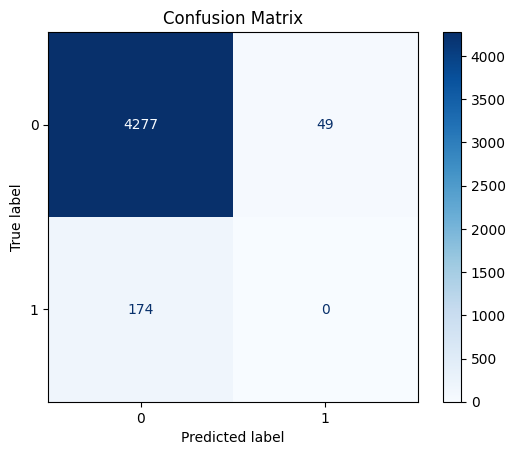

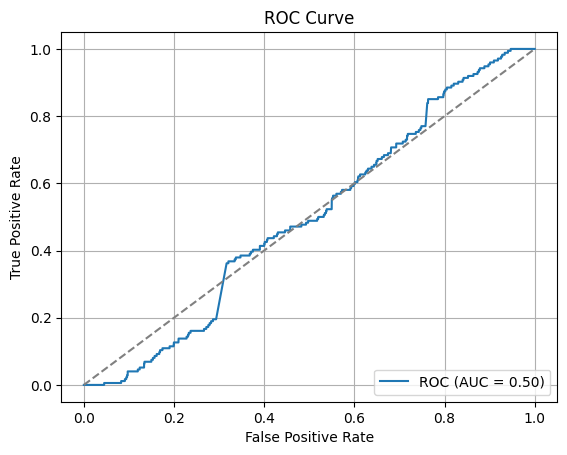

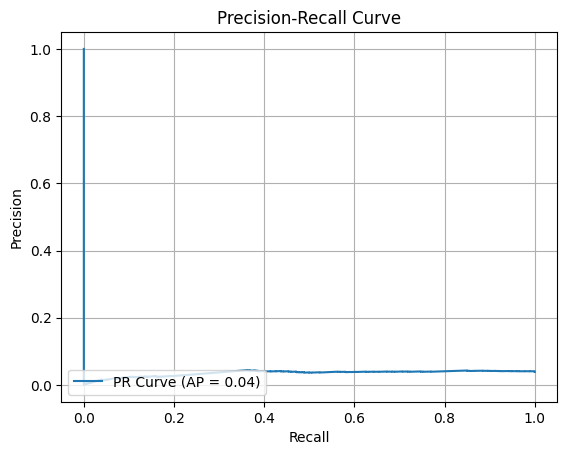

Train  Acc: 0.995,  Validation Acc: 0.942
Train  AUC: 0.999,  Validation AUC: 0.562


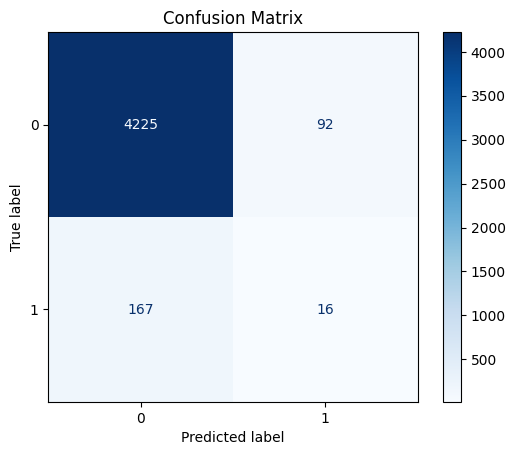

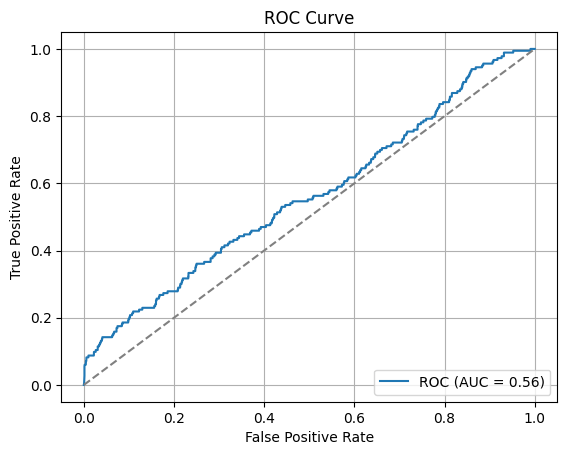

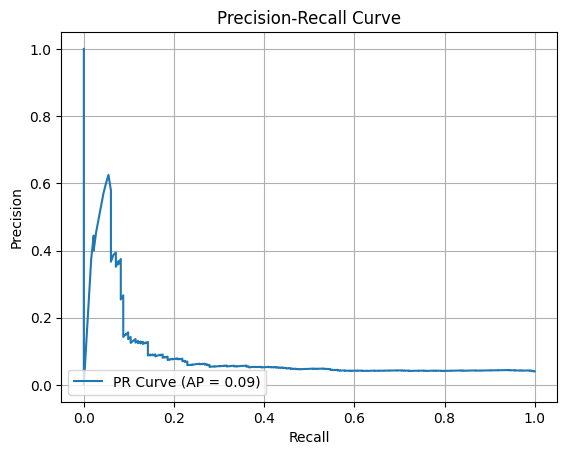

Train  Acc: 0.995,  Validation Acc: 0.952
Train  AUC: 0.999,  Validation AUC: 0.508


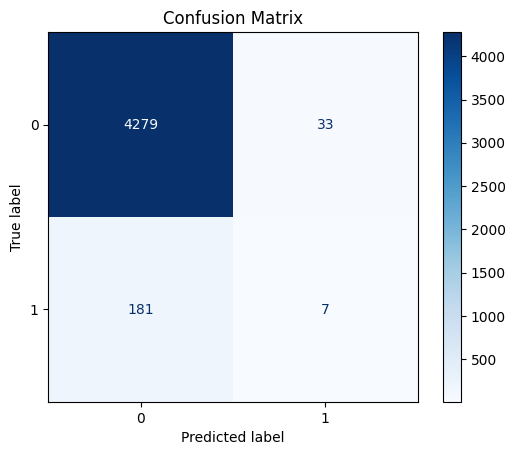

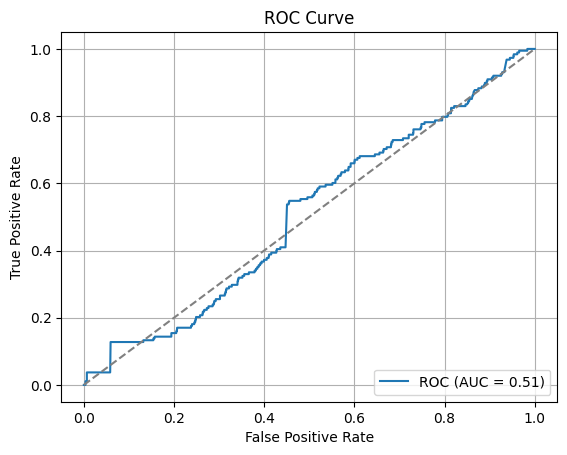

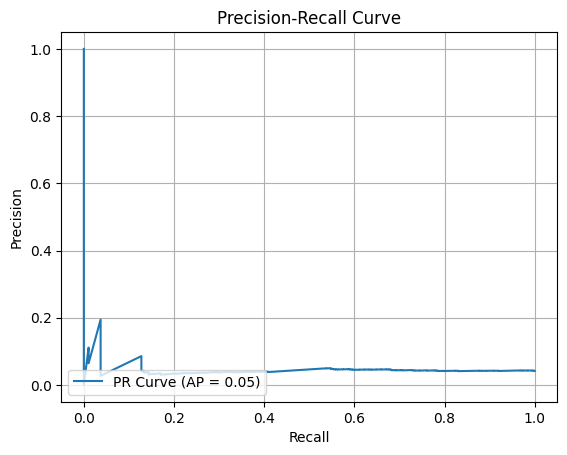

Train  Acc: 0.995,  Validation Acc: 0.930
Train  AUC: 0.999,  Validation AUC: 0.523


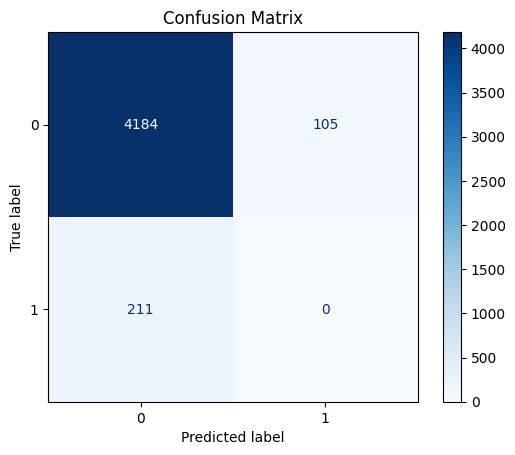

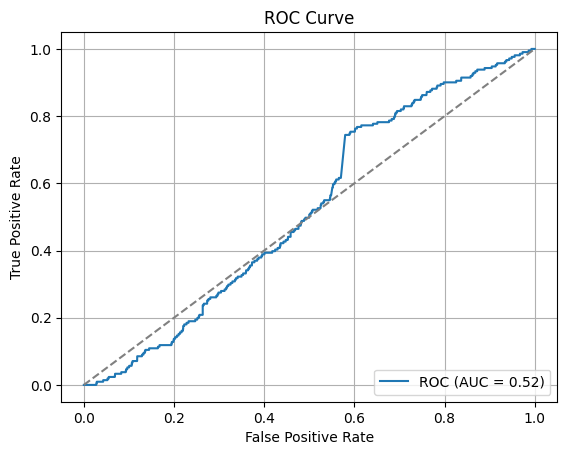

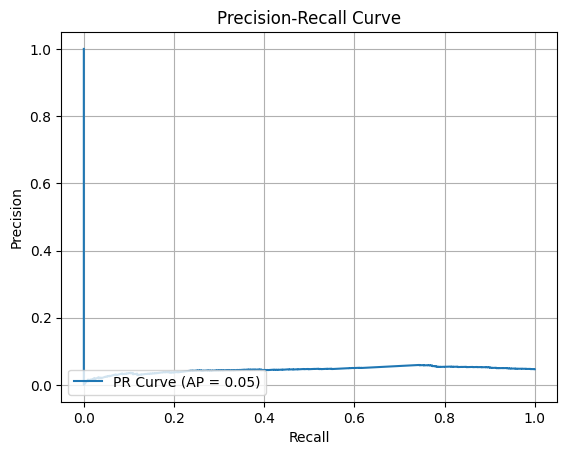

Train  Acc: 0.995,  Validation Acc: 0.933
Train  AUC: 0.999,  Validation AUC: 0.397


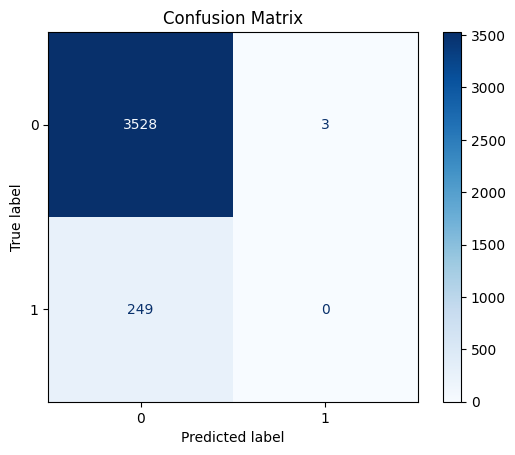

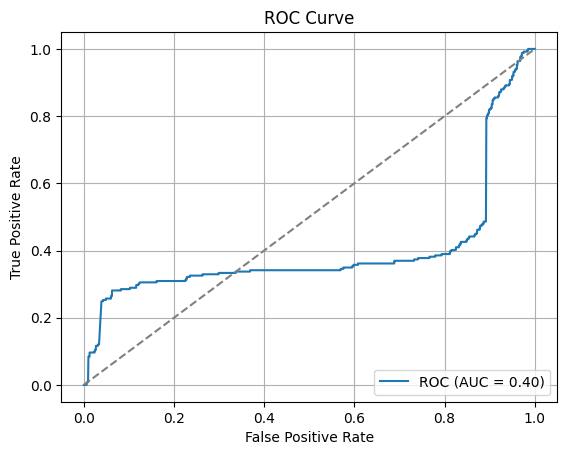

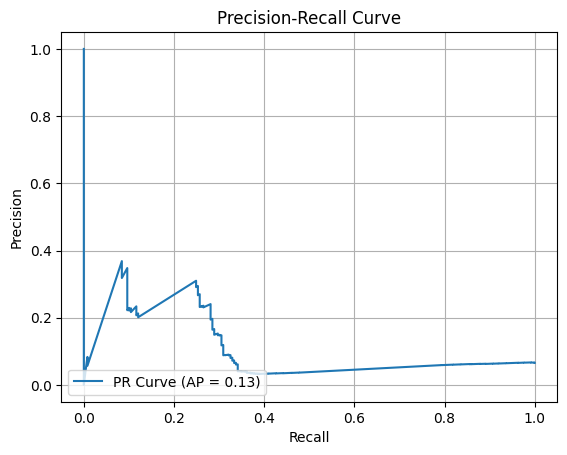

Train  Acc: 0.995,  Validation Acc: 0.957
Train  AUC: 0.999,  Validation AUC: 0.622


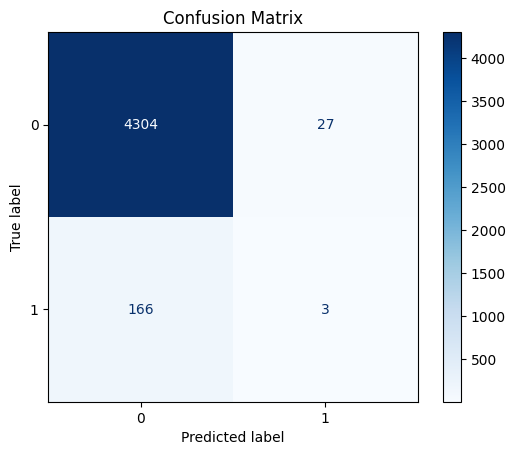

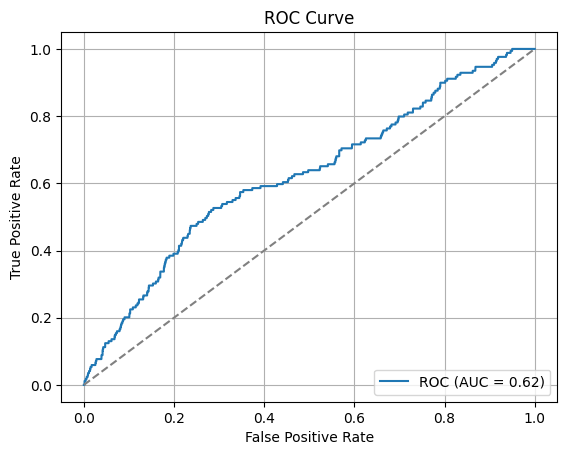

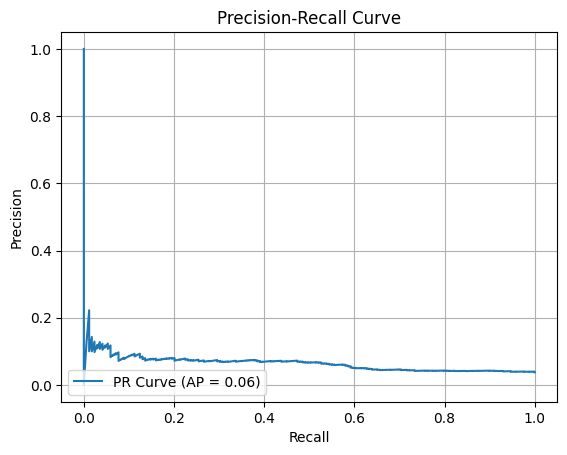

In [18]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc, train_auc, val_auc = train_evaluate_visualize(
        X_tr, y_tr,
        X_vl, y_vl,
        **best_params_week
    )

    modelsSGK.append(model)

In [ ]:
# Define model with best parameters
xbg_res = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', **best_params_user)

# Define scoring metrics
scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']

# Run CV
cv_results = cross_validate(
    xbg_res,
    x,
    targets,
    groups=groups,
    cv=sgkf,
    scoring=scoring,
    return_train_score=True
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Convert to DataFrame
cv_df = pd.DataFrame(cv_results)

# Clean summary table
summary = cv_df[[col for col in cv_df.columns if col.startswith('test_')]].describe().T
summary['metric'] = summary.index.str.replace('test_', '')
summary = summary[['metric', 'mean', 'std']]
summary.reset_index(drop=True, inplace=True)

summary

,metric,mean,std
0,accuracy,0.793633,0.014635
1,roc_auc,0.617046,0.095255
2,precision,0.105556,0.314760
3,recall,0.001222,0.003492
4,f1,0.002416,0.006908


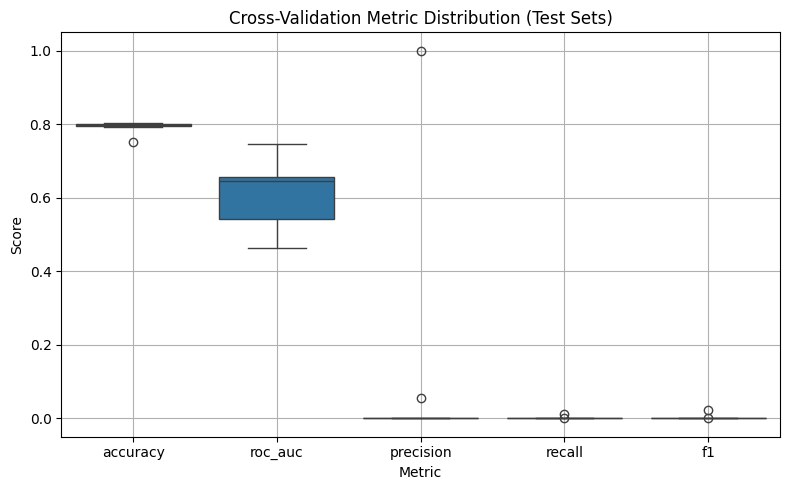

In [ ]:
# Only test metrics
metric_data = {k: v for k, v in cv_results.items() if k.startswith('test_')}
metric_df = pd.DataFrame(metric_data)

# Rename for clarity
metric_df.columns = [col.replace('test_', '') for col in metric_df.columns]
metric_df = metric_df.melt(var_name='Metric', value_name='Score')

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=metric_df, x='Metric', y='Score')
plt.title("Cross-Validation Metric Distribution (Test Sets)")
plt.grid(True)
plt.tight_layout()
plt.show()


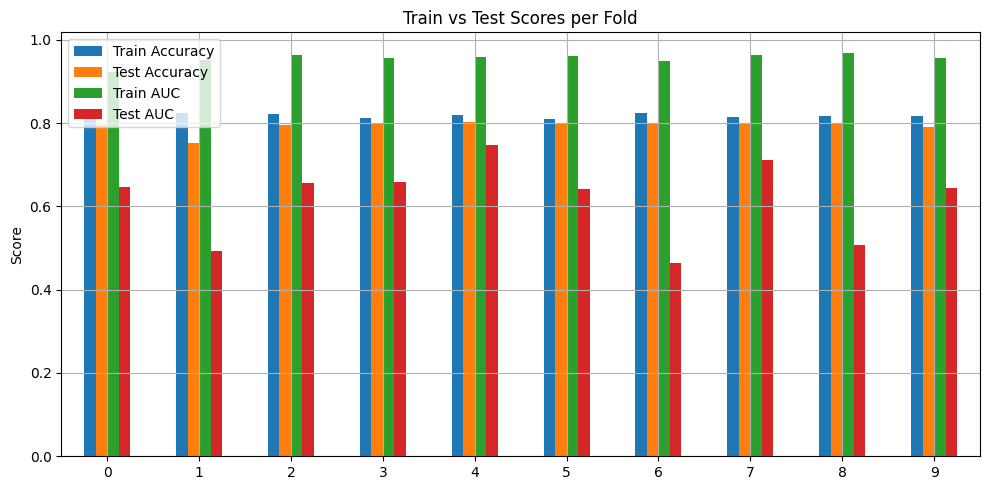

In [ ]:
train_test_df = pd.DataFrame({
    'Train Accuracy': cv_results['train_accuracy'],
    'Test Accuracy': cv_results['test_accuracy'],
    'Train AUC': cv_results['train_roc_auc'],
    'Test AUC': cv_results['test_roc_auc']
})

train_test_df.plot(kind='bar', figsize=(10, 5))
plt.title("Train vs Test Scores per Fold")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


Tuning Decision Threshold

In [ ]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [ ]:
for train_idx, val_idx in sgkf.split(x, targets, groups):
    X_train, X_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = targets.iloc[train_idx], targets.iloc[val_idx]
    groups_train = groups.iloc[train_idx]
    break

In [ ]:
xgb = XGBClassifier(
    **best_params_user,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_thresh = TunedThresholdClassifierCV(
    estimator=xgb,
    scoring="balanced_accuracy",
    store_cv_results=True,
    cv=StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42).split(
        X_train, y_train, groups_train
    ),
    thresholds = 200,
    refit=True
)

xgb_thresh.fit(X_train, y_train)

# --- Best threshold found ---
best_threshold = xgb_thresh.best_threshold_
print(f"✅ Tuned threshold: {best_threshold:.3f}")


✅ Tuned threshold: 0.184


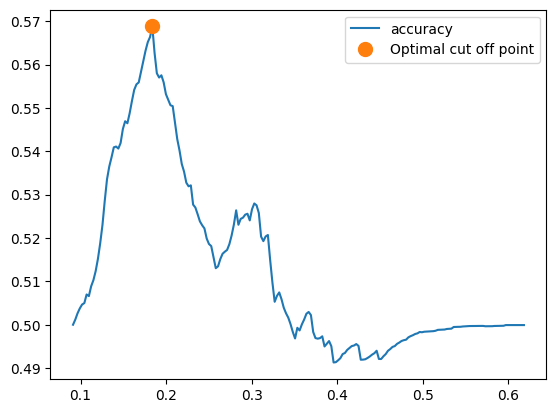

In [ ]:
plt.plot(
    xgb_thresh.cv_results_["thresholds"],
    xgb_thresh.cv_results_["scores"],
    label="accuracy"
)
plt.plot(
    xgb_thresh.best_threshold_,
    xgb_thresh.best_score_,
    "o",
    markersize = 10,
    color ="tab:orange",
    label="Optimal cut off point"
)
plt.legend()


In [ ]:
y_pred_val = xgb_thresh.predict(X_val)

cm = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix on Validation Set:\n", cm)

Confusion Matrix on Validation Set:
 [[1622 1978]
 [ 175  725]]


In [ ]:
# --- Model definition ---
model = XGBClassifier(
    **best_params_user,
    random_state=42,
    n_jobs=-1,
)

# --- Wrapper for threshold tuning ---
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring="balanced_accuracy",
    store_cv_results=True,
    thresholds=200,  # granularity of threshold search
    refit=True
)

# --- Cross-validate outer loop ---
cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

cv_results_tuned_model = pd.DataFrame(
    cross_validate(
        tuned_model,
        x,          # your features
        targets,        # your binary labels
        groups=groups,  # same group used in StratifiedGroupKFold
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True
    )
)

# --- Summary of scores ---
cv_results_tuned_model[
    [col for col in cv_results_tuned_model.columns if "test" in col]
].aggregate(["mean", "std"]).T

,mean,std
test_balanced_accuracy,0.576387,0.076743
test_f1,0.331804,0.115259
test_accuracy,0.593151,0.070301
test_roc_auc,0.586333,0.098760


In [ ]:
thresholds = [est.best_threshold_ for est in cv_results_tuned_model["estimator"]]

# Mean (sensitive to outliers)
mean_threshold = np.mean(thresholds)

# Median (robust to outliers)
median_threshold = np.median(thresholds)

# Trimmed mean: excludes lowest/highest 10%
from scipy.stats import trim_mean
trimmed_threshold = trim_mean(thresholds, proportiontocut=0.1)

print(f"Mean threshold:     {mean_threshold:.3f}")
print(f"Median threshold:   {median_threshold:.3f}")
print(f"Trimmed threshold:  {trimmed_threshold:.3f}")

Mean threshold:     0.214
Median threshold:   0.201
Trimmed threshold:  0.203


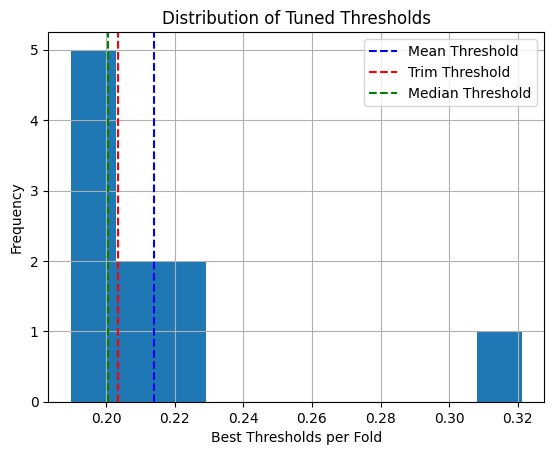

In [ ]:
plt.hist(thresholds, bins=10)
plt.axvline(mean_threshold, color='blue', linestyle='--', label='Mean Threshold')
plt.axvline(trimmed_threshold, color='red', linestyle='--', label='Trim Threshold')
plt.axvline(median_threshold, color='green', linestyle='--', label='Median Threshold')
plt.xlabel("Best Thresholds per Fold")
plt.ylabel("Frequency")
plt.title("Distribution of Tuned Thresholds")
plt.legend()
plt.grid(True)
plt.show()

Evaluating Threshold

In [ ]:
# adjust threshold:
best_threshold = median_threshold

In [ ]:
def train_evaluate_threshold(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    # Probabilities
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_val   = model.predict_proba(X_val)[:, 1]

    # Apply threshold
    y_pred_train = (y_prob_train >= best_threshold).astype(int)
    y_pred_val   = (y_prob_val >= best_threshold).astype(int)

    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc   = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train)
    val_auc   = roc_auc_score(y_val, y_prob_val)

    train_precision = precision_score(y_train, y_pred_train, zero_division=0)
    val_precision   = precision_score(y_val, y_pred_val, zero_division=0)
    train_recall    = recall_score(y_train, y_pred_train, zero_division=0)
    val_recall      = recall_score(y_val, y_pred_val, zero_division=0)
    train_f1        = f1_score(y_train, y_pred_train, zero_division=0)
    val_f1          = f1_score(y_val, y_pred_val, zero_division=0)

    avg_precision = average_precision_score(y_val, y_prob_val)

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("Threshold Used:", best_threshold)
    print("Train Accuracy: {:.3f}, Validation Accuracy: {:.3f}".format(train_acc, val_acc))
    print("Train AUC: {:.3f},     Validation AUC: {:.3f}".format(train_auc, val_auc))
    print("Train F1: {:.3f},      Validation F1: {:.3f}".format(train_f1, val_f1))
    print("Train Precision: {:.3f}, Validation Precision: {:.3f}".format(train_precision, val_precision))
    print("Train Recall: {:.3f},    Validation Recall: {:.3f}".format(train_recall, val_recall))
    print("Validation AP Score: {:.3f}".format(avg_precision))
    print("Validation Sensitivity (TPR): {:.3f}".format(sensitivity))
    print("Validation Specificity (TNR): {:.3f}".format(specificity))
    print("Confusion Matrix:")
    print(cm)

    return {
        "model": model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_auc": train_auc,
        "val_auc": val_auc,
        "train_f1": train_f1,
        "val_f1": val_f1,
        "train_precision": train_precision,
        "val_precision": val_precision,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "val_ap": avg_precision,
        "val_sensitivity": sensitivity,
        "val_specificity": specificity,
        "conf_matrix": cm
    }


Threshold Used: 0.20061925
Train Accuracy: 0.735, Validation Accuracy: 0.575
Train AUC: 0.923,     Validation AUC: 0.646
Train F1: 0.586,      Validation F1: 0.423
Train Precision: 0.432, Validation Precision: 0.291
Train Recall: 0.912,    Validation Recall: 0.779
Validation AP Score: 0.245
Validation Sensitivity (TPR): 0.779
Validation Specificity (TNR): 0.524
Confusion Matrix:
[[1888 1712]
 [ 199  701]]
Threshold Used: 0.20061925
Train Accuracy: 0.776, Validation Accuracy: 0.605
Train AUC: 0.952,     Validation AUC: 0.494
Train F1: 0.633,      Validation F1: 0.367
Train Precision: 0.472, Validation Precision: 0.298
Train Recall: 0.960,    Validation Recall: 0.477
Validation AP Score: 0.231
Validation Sensitivity (TPR): 0.477
Validation Specificity (TNR): 0.645
Confusion Matrix:
[[2206 1214]
 [ 565  515]]
Threshold Used: 0.20061925
Train Accuracy: 0.770, Validation Accuracy: 0.603
Train AUC: 0.963,     Validation AUC: 0.657
Train F1: 0.632,      Validation F1: 0.445
Train Precision: 0

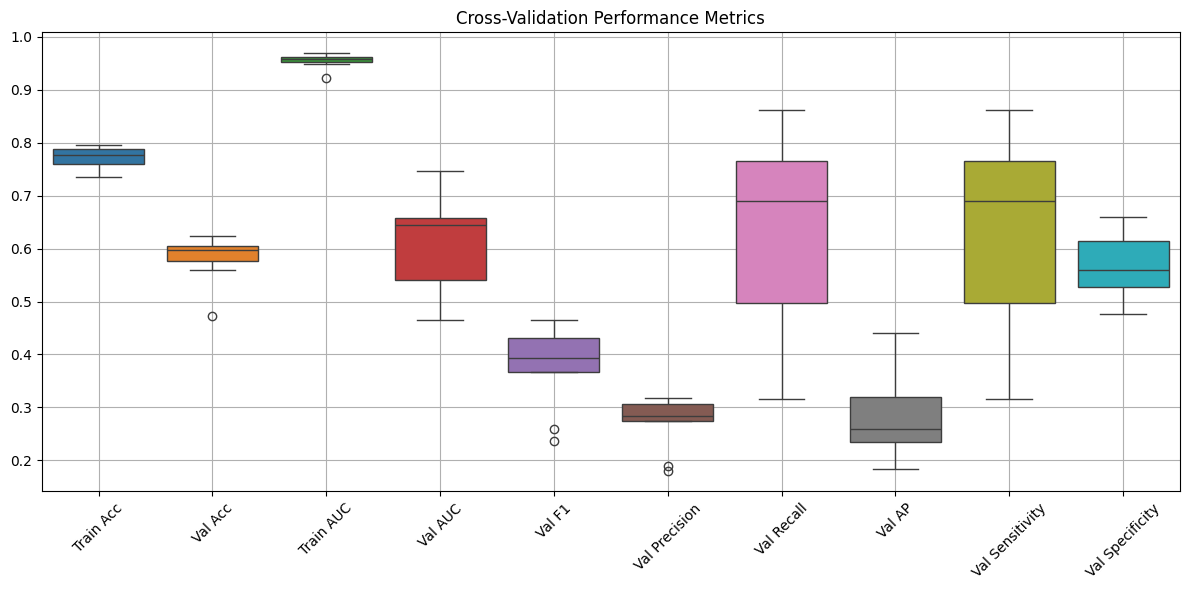

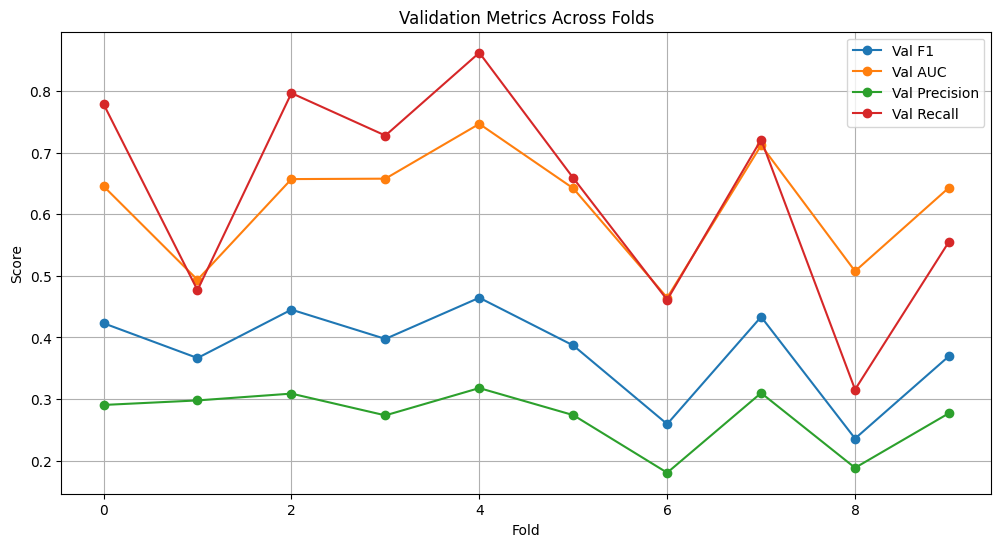

In [ ]:
results = []

for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    res = train_evaluate_threshold(
        X_tr, y_tr,
        X_vl, y_vl,
        **best_params_user
    )

    results.append(res)

metrics_df = pd.DataFrame([
    {
        "Train Acc": r["train_acc"],
        "Val Acc": r["val_acc"],
        "Train AUC": r["train_auc"],
        "Val AUC": r["val_auc"],
        "Val F1": r["val_f1"],
        "Val Precision": r["val_precision"],
        "Val Recall": r["val_recall"],
        "Val AP": r["val_ap"],
        "Val Sensitivity": r["val_sensitivity"],
        "Val Specificity": r["val_specificity"]
    }
    for r in results
])

# Show summary statistics
summary_stats = metrics_df.describe().T
print("=== Summary Stats ===")
print(summary_stats)

# Show boxplot of performance across folds
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df)
plt.title("Cross-Validation Performance Metrics")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for col in ["Val F1", "Val AUC", "Val Precision", "Val Recall"]:
    plt.plot(metrics_df.index, metrics_df[col], marker='o', label=col)

plt.title("Validation Metrics Across Folds")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()
